In [3]:
#importing required libraries

import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Activation,Flatten
from keras.layers import Lambda, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator,load_img
from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings('ignore')


In [4]:
#checking version
print(f'TF verion: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

TF verion: 2.7.0
Keras version: 2.7.0


In [5]:
#setting up seed
seed = 50
def seed_everything(seed):
    os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed)
    

### [To download the dataset I used, click here.](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)

In [6]:
#directories for data 
train_dir = 'Face_Mask_Dataset/Train' #put the directory for train data
test_dir = 'Face_Mask_Dataset' #put the directory for test data
val_dir = 'Face_Mask_Dataset/Validation'##put the directory for validation data

(88, 88, 3)


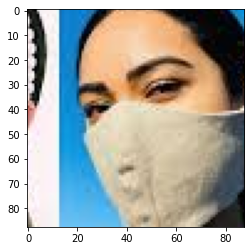

In [7]:
img= load_img('Face_Mask_Dataset/Train/WithMask/14.png')
plt.imshow(img)
print(np.array(img).shape)

(107, 107, 3)


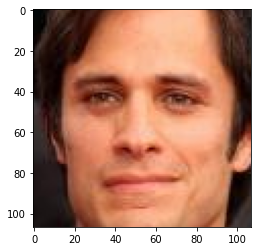

In [8]:
img= load_img('Face_Mask_Dataset/Train/WithoutMask/99.png')
plt.imshow(img)
print(np.array(img).shape)

#### Generate training samples from the following parameters:

In [24]:
input_shape = (120,120,3)
batch_size = 32
epochs = 5
learn_rate = 0.001
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)


In [25]:
#Data Generator


datagen = ImageDataGenerator(
                    rotation_range = 30,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    brightness_range = [0.5,1.5],
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')


datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

In [26]:
train_generator= datagen.flow_from_directory(directory=train_dir,
                                            class_mode="sparse", target_size=(input_shape[0],input_shape[0]), batch_size=batch_size,shuffle = True,
                                             seed = seed,interpolation = "nearest")

Found 10000 images belonging to 2 classes.


In [27]:
val_generator=datagen_val.flow_from_directory(directory=val_dir,
                                            class_mode="sparse", target_size=(input_shape[0],input_shape[0]), batch_size=batch_size,shuffle = True,
                                             seed = seed,interpolation = "nearest")

Found 800 images belonging to 2 classes.


In [28]:
#test datagen

test_generator = datagen_test.flow_from_directory(test_dir,
                                               batch_size = 1, # as we want all images in one batch during prediction (we can take any batch size)
                                               target_size =(input_shape[0],input_shape[0]),
                                                classes=['Test'], # https://kylewbanks.com/blog/loading-unlabeled-images-with-imagedatagenerator-flowfromdirectory-keras
                                               color_mode ='rgb',
                                              seed = seed
                                               ) 

Found 992 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


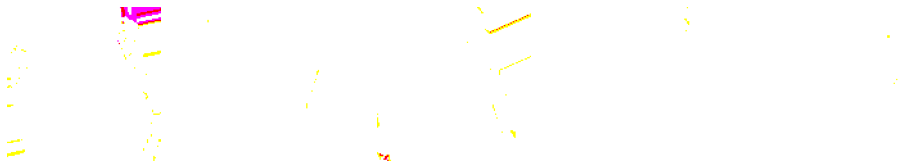

In [29]:
#plotting some images from image generator

fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(16,16))


for i in range (5):
    
    image = next(train_generator)[0][0] # getting images
    
    image = np.squeeze(image) # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    
    ax[i].imshow(image)
    ax[i].axis('off')

In [30]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               mode = 'min',
                               restore_best_weights = True)

# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = 'val_loss',
                             verbose = 1,
                             mode = 'min', 
                             save_best_only = True)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.001,
                              mode = 'min',
                              verbose = 1)

## Building the Model:

In [31]:
from tensorflow.keras.applications import EfficientNetB3
effB3 = EfficientNetB3(input_shape = input_shape, include_top = False, weights = 'imagenet')

In [32]:
#mapping encoded values to class labels

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
n_classes = len(labels)
print(labels) # encode values as keys and class name as valaues. 
print(f'There are total {n_classes} number of classes present')

{0: 'WithMask', 1: 'WithoutMask'}
There are total 2 number of classes present


In [33]:
#creating a function to build the by taking the base model and returning the final model

def build_model(base_modelx):
    
    model = Sequential(base_modelx)
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(256,activation ='relu'))

    model.add(Dense(n_classes,activation='softmax'))
    
    print(model.summary())
    
    model.compile(loss = 'sparse_categorical_crossentropy',optimizer = adam,metrics =['accuracy'])
    
    return model

In [34]:
#build the model

model = build_model(effB3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 4, 4, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,177,521
Trainable params: 11,090,218
Non-trainable params: 87,303
_________________________________________________________________
None


In [22]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

## Model Training:

In [35]:
model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = epochs,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early_stopping, checkpoint, reduce_lr]
                   )

Epoch 1/5
312/312 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9712
Epoch 00001: val_loss improved from inf to 0.00868, saving model to best_model.hdf5
312/312 [==============================] - 913s 3s/step - loss: 0.0860 - accuracy: 0.9712 - val_loss: 0.0087 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 2/5
312/312 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9897
Epoch 00002: val_loss did not improve from 0.00868
312/312 [==============================] - 805s 3s/step - loss: 0.0326 - accuracy: 0.9897 - val_loss: 0.0114 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 3/5
312/312 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9911
Epoch 00003: val_loss did not improve from 0.00868
312/312 [==============================] - 803s 3s/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.0089 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 4/5
312/312 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9920

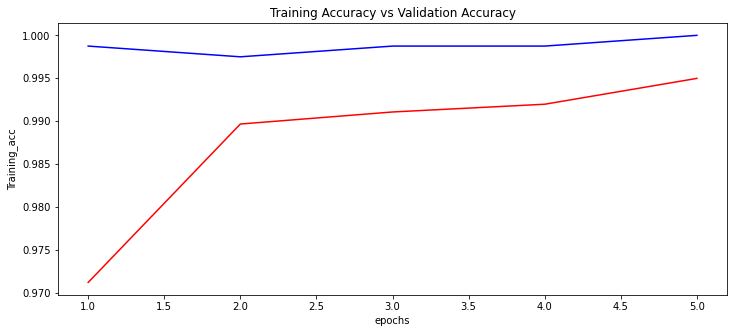

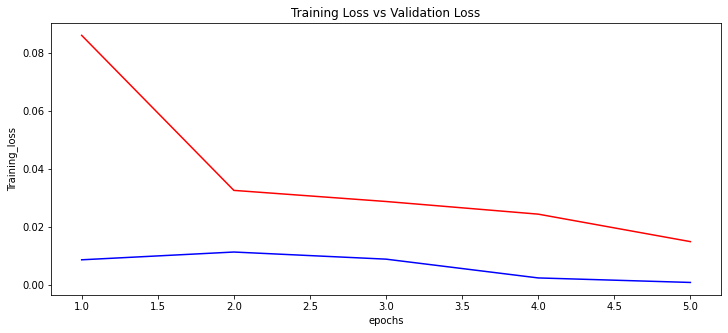

In [36]:
#Ploting acc and loss

def plot_result(modelx):
    results = pd.DataFrame({'epochs':list(range(1,len(modelx.history.history['accuracy'])+1)),'Training_acc':modelx.history.history['accuracy'],'Validation_acc':modelx.history.history['val_accuracy'],
                          'Training_loss':modelx.history.history['loss'],'Validation_loss':modelx.history.history['val_loss']})

    plt.figure(figsize=(12,5))
    sns.lineplot(x = 'epochs', y ='Training_acc', data = results, color='r' )
    sns.lineplot(x = 'epochs', y ='Validation_acc', data = results, color='blue' )
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(x = 'epochs', y ='Training_loss', data = results, color='r' )
    sns.lineplot(x = 'epochs', y ='Validation_loss', data = results, color='blue' )
    plt.title('Training Loss vs Validation Loss')
    plt.show()

plot_result(model)

In [37]:
#predicting

pred = model.predict(test_generator)
pred

# array index to readable: Modelgives back numbers

array([[1.1729862e-09, 1.0000000e+00],
       [4.1183276e-07, 9.9999964e-01],
       [9.9999833e-01, 1.6335696e-06],
       ...,
       [1.3466486e-11, 1.0000000e+00],
       [1.0000000e+00, 4.9250519e-09],
       [4.7743185e-08, 1.0000000e+00]], dtype=float32)

In [38]:
# First prediction
n=1
print(pred[n])
print(f"Max value (probability of prediction): {np.max(pred[n])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[n])}") 
print(f"Max index: {np.argmax(pred[n])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {labels[(np.argmax(pred[n]))]}")

[4.1183276e-07 9.9999964e-01]
Max value (probability of prediction): 0.9999996423721313
Sum: 1.0
Max index: 1
Predicted label: WithoutMask
